In [ ]:
import cv2
import numpy as np

# Read image
img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/IMG_3490.jpg")

# Convert to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# rgb_planes = cv2.split(img)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)


In [ ]:
# result,type(result)

In [ ]:
import pandas as pd
import numpy as np

# read data

df = pd.read_csv("/home/jiaenliu/final_project/saved.csv")

df.head()

In [ ]:
true_df = df[df['correct'] == True]
true_df.head()

In [ ]:
true_df.to_csv("/home/jiaenliu/final_project/train.csv")

In [ ]:
false_df = df[df['correct'] == False]
false_df.head()

In [ ]:
false_df.to_csv("/Users/liujiaen/Documents/Text_Recognition/final_project/false.csv", index=False)

In [ ]:
true_df.drop(['correct','naive_date_confidence','naive_total_confidence','text'], axis=1, inplace=True)
true_df.head()

In [ ]:
true_df.shape

## Now let us use layoutLMv2 to extract date and amount from the invoice

In [1]:
import os
import cv2
import uuid
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast
from datasets import load_dataset
# from torchvision.datasets.utils import download_file_from_google_drive

In [ ]:
dataset = load_dataset("nielsr/", split="test")

In [ ]:
dataset

In [ ]:
labels = dataset.features['ner_tags'].feature.names
print(labels)

In [ ]:
#  create a label to color mapping
labels = dataset.features['ner_tags'].feature.names
label2color = {label: np.random.randint(0, 255, 3).tolist() for label in labels}


In [ ]:
labels[1:-1]

In [2]:
def get_layoutlmv2(ocr_lang = "fra"):
    feature_extractor = LayoutLMv3FeatureExtractor(ocr_lang=ocr_lang,tesseract_config="--psm 12 --oem 2")
    tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
    # processor = LayoutLMv2Processor(feature_extractor, tokenizer)
    model = LayoutLMv3ForTokenClassification.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-sroie")
    return tokenizer, feature_extractor, model

def get_labels():
    # dataset = load_dataset("darentang/sroie", split="test")
    # define id2label, label2color
    labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']
    id2label = {v: k for v, k in enumerate(labels)}
    label2color = {label: tuple(np.random.randint(0, 255, 3).tolist()) for label in labels}
    label2color = dict((k.lower(), v) for k,v in label2color.items())
    return id2label, label2color

# Unnormalize the bounding box coordinates.
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

# iob to label
def iob_to_label(label):
    return label

In [3]:
def process_image(image, feature_extractor, tokenizer, model, id2label, label2color):
    """
    Process the image and return predictions.

    Args:
        image (PIL.Image): Image to be processed.
        # processor (LayoutLMv2Processor): LayoutLMv2 processor.
        feature_extractor (LayoutLMv2FeatureExtractor): LayoutLMv2 feature extractor.
        tokenizer (LayoutLMv2TokenizerFast): LayoutLMv2 tokenizer.
        model (LayoutLMv2ForTokenClassification): LayoutLMv2 model.
        id2label (dict): Dictionary mapping label id to label name.
        label2color (dict): Dictionary mapping label name to color.
    Returns:
        PIL.Image: Image with predictions drawn on it.
    """
    if not os.path.exists("error_images"):
        os.mkdir("error_images")
    width, height = image.size

    # encode the image, get the bounding boxes and the words
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    # print(encoding_feature_extractor.keys())
    # print(encoding_feature_extractor.words)
    words, boxes = encoding_feature_extractor.words[0], encoding_feature_extractor.boxes[0]
    # print(words)
    text = " ".join(words)
    encoding = tokenizer(words, boxes=boxes, return_offsets_mapping=True, return_tensors="pt", truncation=True)
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    # encoding["image"] = encoding_feature_extractor.pixel_values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for k, v in encoding.items():
        encoding[k] = v.to(device)

    model.to(device)

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    true_predictions = true_predictions[1:-1]
    true_boxes = true_boxes[1:-1]

    # print(len(words),len(true_predictions),len(true_boxes))
    # if length of words, predictions and boxes are not equal, then save the image
    if len(words) != len(true_predictions) or len(words) != len(true_boxes):
        image.save("error_images/" +str(uuid.uuid4()) + ".jpg")
        print(len(words),len(true_predictions),len(true_boxes))
        print("There is an error when processing the image. Please check the error_images folder.")
    # print(words)
    # print(true_predictions)


    json_df = []

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    # print(zip(true_predictions, true_boxes))
    for ix, (prediction, box) in enumerate(zip(true_predictions, true_boxes)):
        predicted_label = iob_to_label(prediction).lower()
        if prediction != 'O':
            json_dict = {}

            json_dict["TEXT"] =  words[ix]
            json_dict["LABEL"] = predicted_label
            
            json_df.append(json_dict)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

    # get the text from the labeled box 
    # print(text)
    return image, text, json_df

In [4]:
tokenizer, feature_extractor, layoutLMv2 = get_layoutlmv2()
id2label, label2color = get_labels()

In [ ]:
id2label,label2color

In [6]:
image = Image.open("/home/jiaenliu/final_project/testimage/4.jpg")

# resize the image
image = image.resize((600, 1200))
image, text, json_df = process_image(image, feature_extractor, tokenizer, layoutLMv2, id2label, label2color)

print(json_df)

/home/jiaenliu/miniconda3/envs/receipt/lib/python3.8/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


95 96 96
There is an error when processing the image. Please check the error_images folder.
[{'TEXT': 'ROCHELLE', 'LABEL': 'i-address'}, {'TEXT': '33', 'LABEL': 'i-address'}, {'TEXT': 'RUE', 'LABEL': 'i-address'}, {'TEXT': 'DE', 'LABEL': 'i-address'}, {'TEXT': 'LA', 'LABEL': 'i-address'}, {'TEXT': 'SCIERIE', 'LABEL': 'i-address'}, {'TEXT': '17000', 'LABEL': 'i-address'}, {'TEXT': 'LA', 'LABEL': 'i-address'}, {'TEXT': 'ROCHELLE', 'LABEL': 'i-address'}, {'TEXT': 'Coéémemes', 'LABEL': 'b-total'}, {'TEXT': '12:24:45', 'LABEL': 'b-date'}]


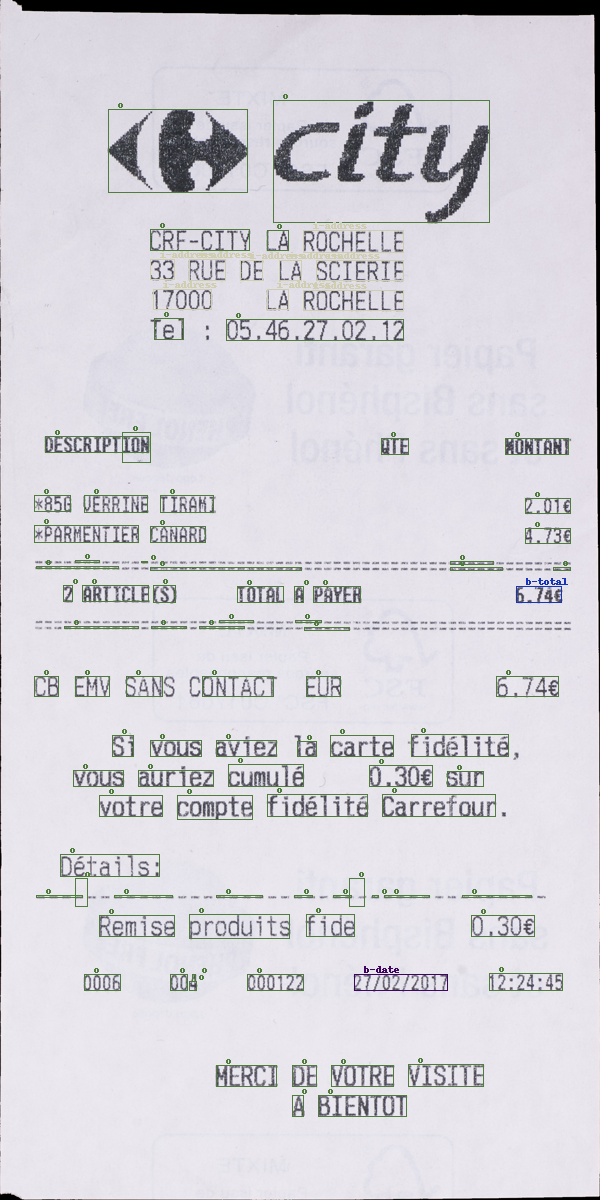

In [7]:
image

In [ ]:
# save the image
image.save("test" + ".jpg")

In [20]:
import pytesseract
from PIL import Image
# /Users/liujiaen/Documents/Text_Recognition/final_project/error_images/2a23868c-23e3-4638-beac-4db7fe220634.jpg
image = Image.open("/home/jiaenliu/final_project/testimage/4.jpg")
data = pytesseract.image_to_data(image, config='--psm 12 --oem 1',output_type='data.frame')
print(data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        1         1          0        0         0         0     0     0   
1        2         1          1        0         0         0   979   316   
2        3         1          1        1         0         0   979   316   
3        4         1          1        1         1         0   979   316   
4        5         1          1        1         1         1   979   316   
..     ...       ...        ...      ...       ...       ...   ...   ...   
309      3         1         57        1         0         0  1140  3609   
310      4         1         57        1         1         0  1140  

In [29]:
torch.cuda.is_available()

True

In [28]:
type(data)

pandas.core.frame.DataFrame

In [25]:
data = data.dropna()

In [27]:
data.head(20)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,979,316,442,341,96.223091,ity
8,5,1,2,1,1,1,436,703,290,62,87.764702,CRF-CITY
9,5,1,2,1,1,2,773,705,65,61,95.012482,LA
10,5,1,2,1,1,3,881,705,290,63,95.012482,ROCHELLE
14,5,1,3,1,1,1,436,794,216,62,1.805199,OooRUE
15,5,1,3,1,1,2,696,795,67,61,73.488022,DE
16,5,1,3,1,1,3,811,796,64,61,58.964672,UA
17,5,1,3,1,1,4,918,796,68,62,19.450089,SC
18,5,1,3,1,1,5,1031,797,137,62,19.450089,BRIE
22,5,1,4,1,1,1,442,884,173,62,96.659927,17000


In [ ]:
image

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
print(is_subword)
print(len(is_subword))

In [ ]:
np.array(offset_mapping.squeeze().tolist())[0:]

In [ ]:
image

In [ ]:
text

In [ ]:
json_df

In [ ]:
import re

In [ ]:
date = []
total = ""
for i in range(len(json_df)):
    if "date" in json_df[i]["LABEL"] :
        # date = json_df[i]["TEXT"]
        date.append(json_df[i]["TEXT"])
        print(json_df[i]["TEXT"])
    elif "total" in json_df[i]["LABEL"]:
        total = re.sub(r'[^\d.]', '', json_df[i]["TEXT"])
        print(float(total))

In [ ]:
# resive the image

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/test_scripts/985.jpg")

# resize the image
img = cv2.resize(img, 600, )

In [ ]:
" ".join(date)

In [ ]:
from dateutil.parser import parse
test = parse(" ".join(date), fuzzy=True)

In [ ]:
test.date()

In [ ]:
import datetime

test.date() == datetime.datetime.strptime(" ".join(date), '%d/%m/%Y').date()

In [ ]:
IMG_PATH = "/Users/liujiaen/Documents/Text_Recognition/dataset/findit/FindIt-Dataset-Train/T1-train/img"



In [ ]:
true_prediction

In [ ]:
text

In [ ]:
image

In [ ]:
import easyocr

reader = easyocr.Reader(['en',"fr"], gpu=False)
result = reader.readtext('/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/66.jpg',detail=0)
result

In [ ]:
" ".join(result)